# Week 3 Assignment
Take a look at the FEC data and do the following:


1. Find three companies and look at if there are patterns in donations in two-week periods.
2. Determine who donates first in those companies.
3. See if you can find the political trends by zip code and compare how they match up to donations.
4. Apply a linear regression model to try to determine if a boss donating to a party causes employees more/less likely to donate to the same party.
5. See the party balance in Colorado.



## FEC Data

In [ ]:
from google.colab import drive

# Load in data
drive.mount('/data/', force_remount = True)
data_dir = '/data/My Drive/EMSE 6574/FEC dataset'
!ls "{data_dir}"

Mounted at /data/
ccl20.zip	     cn20.zip		    oppexp20.zip
ccl_header_file.csv  cn_header_file.csv     pas220.zip
cm20.zip	     indiv20.zip	    pas2_header_file.csv
cm_header_file.csv   indiv_header_file.csv


In [ ]:
from zipfile import ZipFile
import pandas as pd

# Just load in 2020 data
timeframes_of_interest = [
    '20191230_20200130',
    '20200131_20200219',
    '20200220_20200305',
    '20200306_20200330',
    '20200331_20200426',
    '20200427_20200516',
    '20200517_20200603',
    '20200603_20200617',
    '20200618_20200629',
    '20200630_20300630'
]

print('=====INDIVIDUAL CONTRIBUTIONS=====')
print(f'Loading in indiv20 header file...', end = '')
headers = pd.read_csv(f'{data_dir}/indiv_header_file.csv')
print('done!')

individual_contribs = pd.DataFrame()
for timeframe in timeframes_of_interest:
    print(f'Loading in {timeframe} TXT file...', end = '')
    with ZipFile(f'{data_dir}/indiv20.zip') as zfile:
        timeframe_df = pd.read_csv(
            zfile.open(f'by_date/itcont_2020_{timeframe}.txt'),
            sep = '|',
            names = headers.columns
        )

        individual_contribs = individual_contribs.append(
            timeframe_df, ignore_index = True
        )

        del timeframe_df
    print('done!')

print('=====COMMITTEE INFO=====')
print('Loading in cm20 header file...', end = '')
headers = pd.read_csv(f'{data_dir}/cm_header_file.csv')
print('done!')

print('Loading in committee TXT file...', end = '')
with ZipFile(f'{data_dir}/cm20.zip') as zfile:
    committees = pd.read_csv(
        zfile.open('cm.txt'),
        sep = '|',
        names = headers.columns
    )
print('done!')

=====INDIVIDUAL CONTRIBUTIONS=====
Loading in indiv20 header file...done!
Loading in 20191230_20200130 TXT file...

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,10,15,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


done!
Loading in 20200131_20200219 TXT file...

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


done!
Loading in 20200220_20200305 TXT file...

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


done!
Loading in 20200306_20200330 TXT file...done!
Loading in 20200331_20200426 TXT file...done!
Loading in 20200427_20200516 TXT file...

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


done!
Loading in 20200517_20200603 TXT file...

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11,12,15,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


done!
Loading in 20200603_20200617 TXT file...done!
Loading in 20200618_20200629 TXT file...done!
Loading in 20200630_20300630 TXT file...done!
=====COMMITTEE INFO=====
Loading in cm20 header file...done!
Loading in committee TXT file...done!


In [ ]:
individual_contribs.head()

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID
0,C00711317,A,YE,G2020,202007159250113501,15E,IND,"HARDY, IAN",GRAND RAPIDS,MI,495062855,INDEXDATA,SYSTEMS ADMINISTRATOR,12312019,25,C00401224,VVC8RQGD1X7,1424901,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4080820201813425014
1,C00711317,A,YE,G2020,202007159250113503,15E,IND,"HEERSPINK, JANICE",GRAND RAPIDS,MI,495467521,NOT EMPLOYED,NOT EMPLOYED,12312019,25,C00401224,VVC8RQGD1G6,1424901,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4080820201813425020
2,C00711317,A,YE,G2020,202007159250113508,15E,IND,"HISKES, ANNE",GRAND RAPIDS,MI,495466408,GRAND VALLEY STATE UNIVERSITY,HIGHER EDUCATION ADMINISTRATION,12312019,50,C00401224,VVC8RQGD065,1424901,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4080820201813425035
3,C00711317,A,YE,G2020,202007159250113544,15E,IND,"MACKINNON, ERICA",DETROIT,MI,482141896,YANKEE PEDDLER INC.,EXECUTIVE PRODUCER,12312019,350,C00401224,VVC8RQGD142,1424901,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4080820201813425141
4,C00711317,A,YE,G2020,202007159250113553,15E,IND,"MOBLO, BRIE",GRAND RAPIDS,MI,495063222,SELF EMPLOYED,LABORER,12302019,25,C00401224,VVC8RQGD1Q0,1424901,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4080820201813425169


### Political Contributions by Companies

Let's first take an overall look at the contributions by company for the 2020 period.

In [ ]:
# Set row display options to show more than default
pd.set_option('display.min_rows', 30)

# First group by name and employer to get unique names and employers
indiv_contrib_grp_1 = individual_contribs.groupby(['NAME', 'EMPLOYER'])['TRAN_ID'].count()

# Reset index to get back "NAME" and "EMPLOYER" columns
indiv_contrib_grp_1 = indiv_contrib_grp_1.reset_index()

# Then group by employer to see how many people made a transaction in each employer
indiv_contrib_grp_1.groupby('EMPLOYER')['NAME'].nunique().sort_values(ascending = False)

EMPLOYER
RETIRED                                   417560
NOT EMPLOYED                              321791
SELF-EMPLOYED                             118690
NONE                                      109677
SELF                                       74478
SELF EMPLOYED                              64630
HOMEMAKER                                   9090
ENTREPRENEUR                                5354
FEDERAL AVIATION ADMINISTRATION             5184
NOT-EMPLOYED                                4356
LOCKHEED MARTIN                             3328
BOEING                                      3239
USPS                                        3178
MICROSOFT                                   2963
RAYTHEON COMPANY                            2815
                                           ...  
NORTHUMBERLAND NATIONAL BANK                   1
NORTHUMC INDIANAPOLIS IN                       1
NORTHUP GRUMAN                                 1
NORTHUP GRUMMAN                                1
NORTHVIEW C

As we can see from the results above, some of the top companies with donations are the F.A.A., Lockheed Martin, and Boeing. Interesting that the top three are aviation-related agencies/companies. The fourth and fifth are the U.S.P.S. and Microsoft. Let's dig a little deeper and see if we can find some two-week spans where a bunch of employees from a single company donated.

### Two-Week Donation Patterns for Companies

In [ ]:
# Convert "TRANSACTION_DT" column into datetime format
individual_contribs['TRANSACTION_DT'] = pd.to_datetime(individual_contribs['TRANSACTION_DT'], format = '%m%d%Y')

# Check new output
display(individual_contribs.head())

# Filter down to specific employers
lockheed_martin_contribs = individual_contribs[individual_contribs['EMPLOYER'] == 'LOCKHEED MARTIN']
boeing_contribs = individual_contribs[individual_contribs['EMPLOYER'] == 'BOEING']
faa_contribs = individual_contribs[individual_contribs['EMPLOYER'] == 'FEDERAL AVIATION ADMINISTRATION']

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID
0,C00711317,A,YE,G2020,202007159250113501,15E,IND,"HARDY, IAN",GRAND RAPIDS,MI,495062855,INDEXDATA,SYSTEMS ADMINISTRATOR,2019-12-31,25,C00401224,VVC8RQGD1X7,1424901,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4080820201813425014
1,C00711317,A,YE,G2020,202007159250113503,15E,IND,"HEERSPINK, JANICE",GRAND RAPIDS,MI,495467521,NOT EMPLOYED,NOT EMPLOYED,2019-12-31,25,C00401224,VVC8RQGD1G6,1424901,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4080820201813425020
2,C00711317,A,YE,G2020,202007159250113508,15E,IND,"HISKES, ANNE",GRAND RAPIDS,MI,495466408,GRAND VALLEY STATE UNIVERSITY,HIGHER EDUCATION ADMINISTRATION,2019-12-31,50,C00401224,VVC8RQGD065,1424901,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4080820201813425035
3,C00711317,A,YE,G2020,202007159250113544,15E,IND,"MACKINNON, ERICA",DETROIT,MI,482141896,YANKEE PEDDLER INC.,EXECUTIVE PRODUCER,2019-12-31,350,C00401224,VVC8RQGD142,1424901,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4080820201813425141
4,C00711317,A,YE,G2020,202007159250113553,15E,IND,"MOBLO, BRIE",GRAND RAPIDS,MI,495063222,SELF EMPLOYED,LABORER,2019-12-30,25,C00401224,VVC8RQGD1Q0,1424901,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4080820201813425169


We should use the `resample` method for DataFrames to count transactions in 14-day windows for each of the companies.

#### Lockheed Martin
The most contributions seem to have come in in the two-week period starting 12-30-2019 to 01-12-2020 with 2,616 unique people making contributions in that period.

In [ ]:
# Lockheed Martin 14-day contribution counts
lockheed_martin_contribs.set_index('TRANSACTION_DT').resample('14D')['NAME'].nunique()

TRANSACTION_DT
2019-12-30    2616
2020-01-13      13
2020-01-27     378
2020-02-10     138
2020-02-24     971
2020-03-09     131
2020-03-23    1065
2020-04-06      80
2020-04-20    1342
2020-05-04     102
2020-05-18    1765
2020-06-01     159
2020-06-15     175
2020-06-29    1769
2020-07-13      64
2020-07-27    1740
2020-08-10       1
2020-08-24       0
2020-09-07       0
2020-09-21      15
2020-10-05      31
2020-10-19       7
2020-11-02      79
2020-11-16       0
2020-11-30     109
Freq: 14D, Name: NAME, dtype: int64

#### Boeing
For Boeing, contributions jump up starting 01-27-2020 and start climbing up towards a peak of 2,381 in the two-week period starting 06-29-2020.

In [ ]:
# Boeing 14-day contribution counts
boeing_contribs.set_index('TRANSACTION_DT').resample('14D')['NAME'].nunique()

TRANSACTION_DT
2019-12-30     137
2020-01-13      20
2020-01-27     773
2020-02-10     829
2020-02-24    1287
2020-03-09    1213
2020-03-23    1181
2020-04-06    1145
2020-04-20    1245
2020-05-04    1275
2020-05-18    1994
2020-06-01    2033
2020-06-15    2017
2020-06-29    2381
2020-07-13    2292
2020-07-27      79
2020-08-10       1
2020-08-24       0
2020-09-07       0
2020-09-21      35
2020-10-05      65
2020-10-19      17
2020-11-02     140
2020-11-16       0
2020-11-30     389
Freq: 14D, Name: NAME, dtype: int64

#### FAA
The FAA has the majority of contributions at the beginning of the year like Lockheed Martin. 4,862 people made contributions in the two-week period starting on 12-30-2019.

In [ ]:
# FAA 14-day contribution counts by unique person
faa_contribs.set_index('TRANSACTION_DT').resample('14D')['NAME'].nunique()

TRANSACTION_DT
2019-12-30    4862
2020-01-13       1
2020-01-27     251
2020-02-10      24
2020-02-24     717
2020-03-09      14
2020-03-23    1630
2020-04-06       7
2020-04-20    1875
2020-05-04      10
2020-05-18    2592
2020-06-01      13
2020-06-15      17
2020-06-29    3152
2020-07-13       7
2020-07-27    3453
2020-08-10       0
2020-08-24       0
2020-09-07       0
2020-09-21       0
2020-10-05       3
2020-10-19       1
2020-11-02      11
2020-11-16       0
2020-11-30      19
Freq: 14D, Name: NAME, dtype: int64

### Who Donates First: Boss or Employee?
Let's now take a look at if there's a pattern between when a high-level executive donates to a political campaign and when employees of the same company donate to a campaign. We focus particularly on Lockheed Martin and Boeing since both are private-sector companies.

#### Lockheed Martin

In [ ]:
# Select the two-week time period we see the highest contributions
lockheed_martin_max_contribs = lockheed_martin_contribs.set_index('TRANSACTION_DT').loc['2019-12-30':'2020-01-12']
lockheed_martin_max_contribs.head()

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID
TRANSACTION_DT,,,,,,,,,,,,,,,,,,,,
2019-12-31,C00010603,A,YE,G2019,202004279232322993,15E,IND,"HOEFT, ROBERT",ORLANDO,FL,328690575,LOCKHEED MARTIN,ENGINEER,250,NaN,34399264,1403611,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4050420201741684254
2019-12-31,C00010603,A,YE,G2019,202004279232325846,15E,IND,"PALMER, WILLIAM",DURHAM,NC,277055813,LOCKHEED MARTIN,TECHNICAL DIRECTOR,500,NaN,34403053,1403611,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4050420201741692813
2019-12-31,C00161786,A,YE,P,202006199240081356,15E,IND,"PEPPER, ALAN",WHEAT RIDGE,CO,80033,LOCKHEED MARTIN,TECHNICIAN,25,C00401224,11AI-000281310,1413838,NaN,EARMARKED THROUGH ACT BLUE,4062220201776499724
2019-12-31,C00618371,A,YE,P,202007289261029563,15E,IND,"GEBHARDT, MATT",COLORADO SPRINGS,CO,80920,LOCKHEED MARTIN,ENGINEER,200,NaN,SA11AI.251725,1429032,NaN,NaN,4080420201811600730
2019-12-30,C00696948,A,YE,P2020,202003309216048191,15E,IND,"BADOLATO, CHRISTIAN",ABINGDON,MD,210091656,LOCKHEED MARTIN,SOFTWARE ENGINEER,2,C00401224,15130571,1392261,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4041420201735699230


In [ ]:
# What dates are executives making donations?
lockheed_martin_max_contribs[lockheed_martin_max_contribs['OCCUPATION'].str.lower().str.contains('ceo')]

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID
TRANSACTION_DT,,,,,,,,,,,,,,,,,,,,
2019-12-31,C00303024,N,YE,P,202001289167423783,15,IND,"LEVIN, LON C",ARLINGTON,VA,222024135,LOCKHEED MARTIN,PRESIDENT & CEO GEOSHARE,200,NaN,PR2361125168602,1374104,NaN,P/R DEDUCTION ($50.00 WEEKLY),4012920201686061377
2019-12-31,C00303024,N,YE,P,202001289167424251,15,IND,"HEWSON, MARILLYN ADAMS",BETHESDA,MD,208171803,LOCKHEED MARTIN,CHAIRMAN PRESIDENT AND CEO,384,NaN,PR372557368602,1374104,NaN,P/R DEDUCTION ($96.15 WEEKLY),4012920201686062782


In [ ]:
# How many contributions happened before/after 12-31-2019?
print(f'{lockheed_martin_max_contribs.loc["2019-12-30"].shape[0]} transactions happened before 12-31-2019.')
print(f'{lockheed_martin_max_contribs.loc["2019-12-31":].shape[0]} transactions happened on or after 12-31-2019.')

64 transactions happened before 12-31-2019.
2637 transactions happened on or after 12-31-2019.


It looks like after the CEO of Lockheed Martin donated money, a bunch of contributions came afterwards in that two-week period.

#### Boeing

In [ ]:
# Select the two-week time period we see the highest contributions
boeing_max_contribs = boeing_contribs.set_index('TRANSACTION_DT').loc['2020-06-29':'2020-07-12']
boeing_max_contribs.head()

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID
TRANSACTION_DT,,,,,,,,,,,,,,,,,,,,
2020-06-29,C00580100,A,M7,P2020,202008209266205995,15E,IND,"DORN, RONALD",O FALLON,MO,63366,BOEING,SALES,25,NaN,SA17A.248163,1434616,NaN,NaN,4090120201831755796
2020-06-29,C00580100,A,M7,P2020,202008209266201168,15E,IND,"CORNWELL, DONALD",SAINT PETERS,MO,63376,BOEING,TEST ENGINEER,25,NaN,SA17A.206781,1434616,NaN,NaN,4090120201831741314
2020-06-29,C00580100,A,M7,P2020,202008209266201168,15E,IND,"CORNWELL, DONALD",SAINT PETERS,MO,63376,BOEING,TEST ENGINEER,100,NaN,SA17A.206780,1434616,NaN,NaN,4090120201831741313
2020-06-29,C00580100,A,M7,P2020,202008209266270301,15E,IND,"WHITENER, DAVID",HUNTINGTON BEACH,CA,92646,BOEING,MECHANIC,50,NaN,SA17A.350187,1434616,NaN,NaN,4090120201831951712
2020-06-29,C00580100,A,M7,P2020,202008209266267842,15E,IND,"W, GLEN",PORT HUENEME,CA,93041,BOEING,ENGINEER,25,NaN,SA17A.439386,1434616,NaN,NaN,4090120201831943335


In [ ]:
# What dates are executives making donations?
boeing_max_contribs = boeing_max_contribs.fillna('')
boeing_max_contribs[boeing_max_contribs['OCCUPATION'].str.lower().str.contains('ceo')]

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID
TRANSACTION_DT,,,,,,,,,,,,,,,,,,,,
2020-07-09,C00142711,N,M8,P,202008179261329374,15,IND,"CARET, LEANNE",ARLINGTON,VA,22202,BOEING,EVP & CEO-PROGRAM MANAGEMENT EXECUTIVE,200,,2020070716135-452,1432738,,,4082920201831179940
2020-07-09,C00142711,N,M8,P,202008179261329498,15,IND,"DEAL, STANLEY",ARLINGTON,VA,22202,BOEING,EVP & CEO-PROGRAM MANAGEMENT EXECUTIVE,200,,2020070716135-1976,1432738,,,4082920201831180312
2020-07-09,C00142711,N,M8,P,202008179261329435,15,IND,"COLBERT, THEODORE III",ARLINGTON,VA,22202,BOEING,EVP & CEO-PROGRAM MANAGEMENT EXECUTIVE,192,,2020070716135-1165,1432738,,,4082920201831180124


In [ ]:
# How many contributions happened before/after 07-09-2020?
print(f'{boeing_max_contribs.loc["2020-07-09"].shape[0]} transactions happened before 07-09-2020.')
print(f'{boeing_max_contribs.loc["2020-07-09":].shape[0]} transactions happened on or after 07-09-2020.')

2227 transactions happened before 07-09-2020.
2263 transactions happened on or after 07-09-2020.


For Boeing, unlike Lockheed Martin, there are an almost equal amount of contributions before and after Boeing executives contributed in the two-week period we found.

### Political Trends by ZIP Code
There aren't really any open datasets that contain political affiliation or congressional district by ZIP code so I focus on a couple ZIP codes in this part, and use https://www.isidewith.com/map/1onjd/support-for-democrats#z10 and https://www.isidewith.com/map/1onnH/support-for-republicans#z11 to determine trends.

#### Lockheed Martin
While there isn't too much data for these particular ZIP codes, we do see that party affiliations of the committees donated to by Lockheed Martin employees match the party trends for that ZIP code.

In [ ]:
# Join committee party affiliation data with individual contribution data
committees['CMTE_ID'] = committees['CMTE_ID'].astype(str)
lockheed_martin_max_contribs['CMTE_ID'] = lockheed_martin_max_contribs['CMTE_ID'].astype(str)
lockheed_martin_max_contribs = lockheed_martin_max_contribs.merge(committees[['CMTE_ID', 'CMTE_NM', 'CMTE_PTY_AFFILIATION']], on = 'CMTE_ID')

# Convert ZIP codes to strings to search for substrings
lockheed_martin_max_contribs['ZIP_CODE'] = lockheed_martin_max_contribs['ZIP_CODE'].astype(str)

In [ ]:
# Let's look at ZIP code 80226 which leans (D)
# and count the donations by committee party affiliation
lockheed_martin_max_contribs[lockheed_martin_max_contribs['ZIP_CODE'].str.contains('80226')]['CMTE_PTY_AFFILIATION'].value_counts()

DEM    8
Name: CMTE_PTY_AFFILIATION, dtype: int64

In [ ]:
# Let's look at ZIP code 19428 which leans (D)
# and count the donations by committee party affiliation
lockheed_martin_max_contribs[lockheed_martin_max_contribs['ZIP_CODE'].str.contains('19428')]['CMTE_PTY_AFFILIATION'].value_counts()

DEM    3
Name: CMTE_PTY_AFFILIATION, dtype: int64

#### Boeing
There isn't much data for these ZIP codes either, but we can see that in one ZIP code, there are contributions to the opposite trending party (74132) while in the other ZIP code, the contributions match the trending party for that ZIP code.

In [ ]:
# Join committee party affiliation data with individual contribution data
committees['CMTE_ID'] = committees['CMTE_ID'].astype(str)
boeing_max_contribs['CMTE_ID'] = boeing_max_contribs['CMTE_ID'].astype(str)
boeing_max_contribs = boeing_max_contribs.merge(committees[['CMTE_ID', 'CMTE_NM', 'CMTE_PTY_AFFILIATION']], on = 'CMTE_ID')

In [ ]:
# Convert ZIP codes to strings to search for substrings
boeing_max_contribs['ZIP_CODE'] = boeing_max_contribs['ZIP_CODE'].astype(str)

# Let's look at ZIP code 74132 which leans (D)
# and count the donations by committee party affiliation
boeing_max_contribs[boeing_max_contribs['ZIP_CODE'].str.contains('74132')]['CMTE_PTY_AFFILIATION'].value_counts()

REP    6
Name: CMTE_PTY_AFFILIATION, dtype: int64

In [ ]:
# Let's look at ZIP code 98270 which leans (D)
# and count the donations by committee party affiliation
boeing_max_contribs[boeing_max_contribs['ZIP_CODE'].str.contains('98270')]['CMTE_PTY_AFFILIATION'].value_counts()

DEM    7
Name: CMTE_PTY_AFFILIATION, dtype: int64

### Linear Regression
Let's see if we can predict whether a person will donate to the same party as his/her boss.

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

#### Feature Engineering

In [ ]:
# Join committee party affiliation data with individual contribution data
committees['CMTE_ID'] = committees['CMTE_ID'].astype(str)
lockheed_martin_contribs['CMTE_ID'] = lockheed_martin_contribs['CMTE_ID'].astype(str)
lockheed_martin_contribs = lockheed_martin_contribs.fillna('')
lockheed_martin_contribs = lockheed_martin_contribs.merge(committees[['CMTE_ID', 'CMTE_NM', 'CMTE_PTY_AFFILIATION']], on = 'CMTE_ID')
lockheed_martin_contribs = lockheed_martin_contribs.fillna('')

# Select only the rows that have a valid committee party affiliation
valid_contributions = lockheed_martin_contribs[~(lockheed_martin_contribs['CMTE_PTY_AFFILIATION'] == '')].copy()

# The Lockheed Martin CEO made most of her contributions to the Lockheed Martin
# PAC which donates to both party. For the sake of this model though, we will
# say that she donated to the Republican party due to the fact that, based on
# Lockheed Martin's 2019 PAC disclosure 
# (https://www.lockheedmartin.com/content/dam/lockheed-martin/eo/documents/governance/LMEPAC-Disbursements-2019.pdf), 
# the majority of their donations went to Republican committees.
# Let's create a column that indicates whether a person's donations matched 
# the CEO's. 1 means a match; 0 means it didn't match.
valid_contributions['matched_CEO'] = np.where(
    valid_contributions['CMTE_PTY_AFFILIATION'] == 'REP', 1, 0
)

# Now we should one-hot encode the party affiliations of donations
# so the linear regression model can accept it
one_hot_encoder = OneHotEncoder(sparse = False)
X = one_hot_encoder.fit_transform(valid_contributions['CMTE_PTY_AFFILIATION'].values.reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Model Building 

In [ ]:
y = valid_contributions['matched_CEO']
linear_regressor = LinearRegression()
linear_regressor.fit(X, y);

In [ ]:
# Let's see what the model predicts when we pass in features.
# Features should be in the form of an array of five binary
# indicators: [DEM, DFL, LIB, NNE, REP, UNK]. A 1 in a particular
# location indicates the contribution was for a committee of that party.
# e.g., [1, 0, 0, 0, 0, 0] means the contribution was made to a DEM committee.
# The result should be close to 1 if it matches and close to 0 if it doesn't.
linear_regressor.predict([[1, 0, 0, 0, 0, 0]])

array([1.32367533e-16])

### Party Balance in CO
Let's take a look at party balance between executives and employees. Party balance is calculated by creating a score between -1 and 1 depending on contributions to a particular committee. The closer to -1, the more Republican and the closer to 1, the more Democrat. Do employees have the same party balance as executives?

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Pull the executives from CO
co_execs = individual_contribs[
    (individual_contribs['STATE'] == 'CO')
    & (individual_contribs['OCCUPATION'].str.lower().str.contains('executive'))
].merge(committees[['CMTE_ID', 'CMTE_NM', 'CMTE_PTY_AFFILIATION']], on = 'CMTE_ID')

# Create a "score" for each contribution: 1 for DEM, -1 for REP, 0 for all others
co_execs['contrib_score'] = np.where(
    co_execs['CMTE_PTY_AFFILIATION'] == 'DEM', 1, 
    np.where(co_execs['CMTE_PTY_AFFILIATION'] == 'REP', -1, 0)
)

# Calculate the party balance by summing over the `contrib_score` column
# and dividing by the number of transactions
def party_score(rows):
    return rows.sum() / rows.shape[0]

co_execs_scores = co_execs.groupby('NAME')['contrib_score'].agg(party_score)

In [ ]:
# Pull the employees from CO
co_emps = individual_contribs[
    (individual_contribs['STATE'] == 'CO')
    & ~(individual_contribs['OCCUPATION'].str.lower().str.contains('executive', na = False))
].merge(committees[['CMTE_ID', 'CMTE_NM', 'CMTE_PTY_AFFILIATION']], on = 'CMTE_ID')

# Create a "score" for each contribution: 1 for DEM, -1 for REP, 0 for all others
co_emps['contrib_score'] = np.where(
    co_emps['CMTE_PTY_AFFILIATION'] == 'DEM', 1, 
    np.where(co_emps['CMTE_PTY_AFFILIATION'] == 'REP', -1, 0)
)

# Calculate the party balance by summing over the `contrib_score` column
# and dividing by the number of transactions
def party_score(rows):
    return rows.sum() / rows.shape[0]

co_emps_scores = co_emps.groupby('NAME')['contrib_score'].agg(party_score)

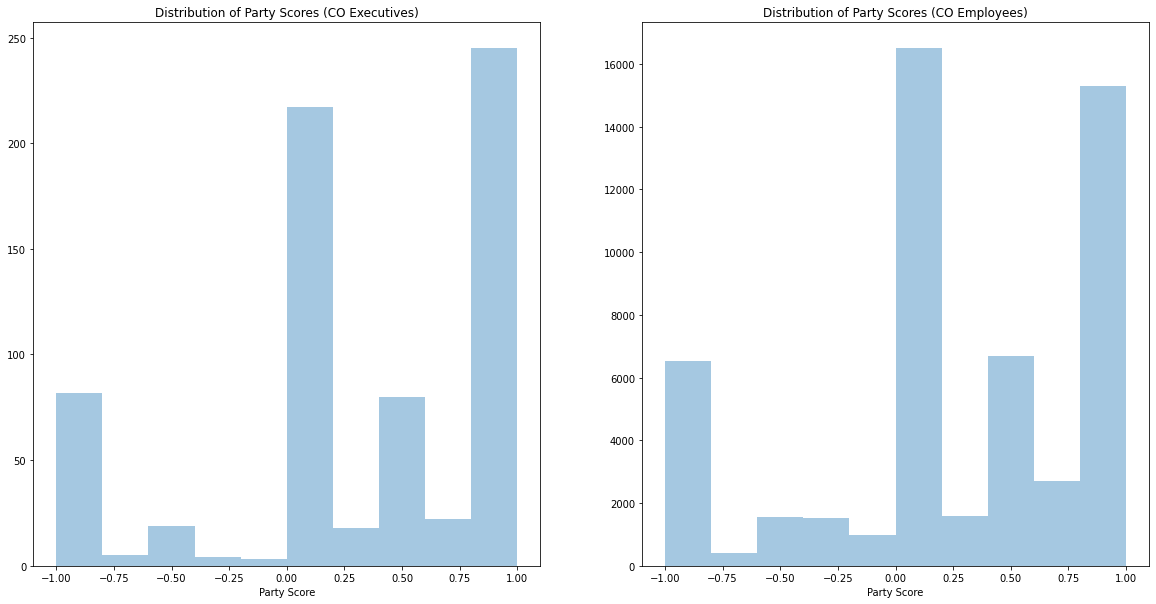

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (20, 10))
sns.distplot(co_execs_scores, bins = 10, kde = False, ax = axs[0]);
axs[0].set_title('Distribution of Party Scores (CO Executives)');
axs[0].set_xlabel('Party Score');

sns.distplot(co_emps_scores, bins = 10, kde = False, ax = axs[1]);
axs[1].set_title('Distribution of Party Scores (CO Employees)');
axs[1].set_xlabel('Party Score');

Based on the plots above, we can see that it looks like the employees basically have the same party balance as executives in CO. The only difference is that employees tend to be more in the middle versus Democrat while it's the opposite for executives.